In [313]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import scipy.stats as stats
import tensorflow as tf


# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


# Data Load

In [314]:
# Load the trainng and data sets
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

#shuffle the training data
train_df = train_df.reindex(np.random.permutation(train_df.index))

test_df.head()

# merge train and test data for common data processingg
merged = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Storing Id for submission
Id = test_df.Id

# **Exploratory Data Analysis**

Investigate the data descriptions provided

In [315]:
# Using python's inbuilt function `open()` to read text data

data_description = open("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt", "r")
print(data_description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Look at shape of the data

In [316]:
# Look to shape's
print('Train dataset have ', train_df.shape[0], ' lines and ', train_df.shape[1], ' columns')
print('Test dataset have ', test_df.shape[0], ' lines and ', test_df.shape[1], ' columns')

Train dataset have  1460  lines and  81  columns
Test dataset have  1459  lines and  80  columns


Add booleans for whether key features are present or not

In [317]:
merged['isBasement'] = merged['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
merged['isFireplace'] = merged['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
merged['isPool'] = merged['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
merged['is2Floors'] = merged['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
merged['isGarage'] = merged['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

Three columns for square footage.  Basement, first floor and second floor.  Sum these to give overall square footage.

In [318]:
merged['TotalSF'] = merged['TotalBsmtSF'] + merged['1stFlrSF'] + merged['2ndFlrSF']
merged = merged.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1)


merged['TotalBathrooms'] = merged['FullBath'] + (0.5 * merged['HalfBath']) + merged['BsmtFullBath'] + (0.5 * merged['BsmtHalfBath'])
merged = merged.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], axis = 1)

In [319]:
# Fill in Lot Frontage based upon median value per Neighbourhood
merged['LotFrontage'] = merged.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


# Label - Sale Price distribution
Is it evenly distributed?  If not then can we improve.

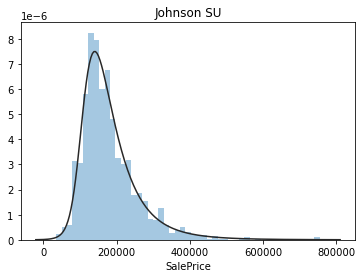

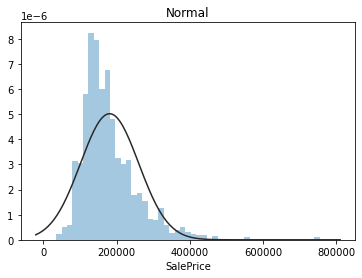

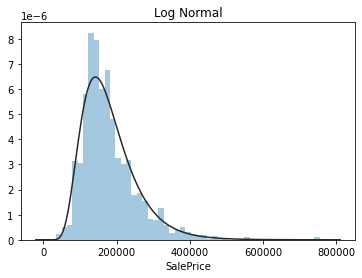

In [320]:
y = train_df['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

Choose Johnson as best fit.

In [321]:
merged["SalePrice"] = np.log1p(merged["SalePrice"])

# Correlations
Check what columns correlate best with the sale price.

In [322]:
merged = merged[['LotFrontage','YearBuilt','YearRemodAdd','isFireplace','TotalBathrooms','GarageCars','GarageArea','GarageYrBlt','GrLivArea','TotalSF','SalePrice']]


Select the top columns (in green) from above

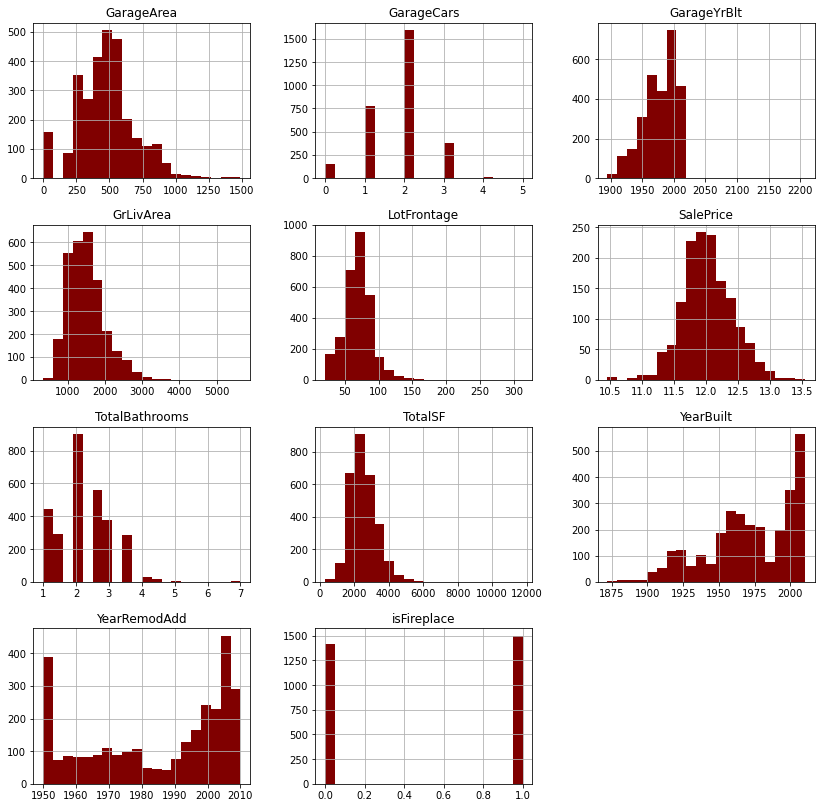

In [323]:
merged.hist(figsize=(14,14), color='maroon', bins=20)
plt.show()

In [324]:
merged.dtypes

LotFrontage       float64
YearBuilt           int64
YearRemodAdd        int64
isFireplace         int64
TotalBathrooms    float64
GarageCars        float64
GarageArea        float64
GarageYrBlt       float64
GrLivArea           int64
TotalSF           float64
SalePrice         float64
dtype: object

In [325]:
# Look at columns in order of percentage missing values 
merged.isnull().mean().sort_values(ascending=False)

SalePrice         0.499829
GarageYrBlt       0.054471
TotalBathrooms    0.000685
TotalSF           0.000343
GarageArea        0.000343
GarageCars        0.000343
GrLivArea         0.000000
isFireplace       0.000000
YearRemodAdd      0.000000
YearBuilt         0.000000
LotFrontage       0.000000
dtype: float64

In [326]:
# Fill in nulls 
merged['TotalSF'].fillna((merged['TotalSF'].mean()), inplace=True)
merged['GarageArea'].fillna((merged['GarageArea'].mean()), inplace=True)
merged['GarageCars'].fillna((merged['GarageCars'].mean()), inplace=True)
merged['GarageYrBlt'].fillna((merged['GarageYrBlt'].mean()), inplace=True)
merged['TotalBathrooms'].fillna((merged['TotalBathrooms'].mean()), inplace=True)

In [327]:
merged.head()

,LotFrontage,YearBuilt,YearRemodAdd,isFireplace,TotalBathrooms,GarageCars,GarageArea,GarageYrBlt,GrLivArea,TotalSF,SalePrice
0,73.0,1960,1960,1,2.5,1.0,352.0,1960.000000,1253,2506.0,11.964007
1,72.0,1956,1956,0,2.0,1.0,286.0,1956.000000,1048,2096.0,11.813037
2,168.0,2006,2006,1,2.5,2.0,422.0,2006.000000,2021,2889.0,12.523530
3,55.0,1940,1966,0,1.0,0.0,0.0,1978.113406,1306,2034.0,11.245059
4,50.0,1920,1950,0,1.0,1.0,308.0,1997.000000,960,1920.0,11.594515


In [328]:
# One-hot encode
merged_oh = pd.get_dummies(merged)
merged_oh.head()

,LotFrontage,YearBuilt,YearRemodAdd,isFireplace,TotalBathrooms,GarageCars,GarageArea,GarageYrBlt,GrLivArea,TotalSF,SalePrice
0,73.0,1960,1960,1,2.5,1.0,352.0,1960.000000,1253,2506.0,11.964007
1,72.0,1956,1956,0,2.0,1.0,286.0,1956.000000,1048,2096.0,11.813037
2,168.0,2006,2006,1,2.5,2.0,422.0,2006.000000,2021,2889.0,12.523530
3,55.0,1940,1966,0,1.0,0.0,0.0,1978.113406,1306,2034.0,11.245059
4,50.0,1920,1950,0,1.0,1.0,308.0,1997.000000,960,1920.0,11.594515


In [329]:
# Look at columns in order of percentage missing values 
merged_oh.isnull().mean().sort_values(ascending=False)

SalePrice         0.499829
TotalSF           0.000000
GrLivArea         0.000000
GarageYrBlt       0.000000
GarageArea        0.000000
GarageCars        0.000000
TotalBathrooms    0.000000
isFireplace       0.000000
YearRemodAdd      0.000000
YearBuilt         0.000000
LotFrontage       0.000000
dtype: float64

In [330]:
# Splitting dataset into train
train = merged_oh[:len(train_df)]

# Splitting dataset into test
test = merged_oh[len(train_df):]

# Drop labels 'Survived' because there shouldn't be a Survived column in the test data
test.drop(labels=['SalePrice'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [331]:
# load up train/validation set! 
train_size = int(train.shape[0] * 0.85)

train_dataset = train[:train_size]
val_dataset = train[train_size:]

X_train = train_dataset.drop(labels=["SalePrice"], axis=1).values
Y_train = train_dataset["SalePrice"].values

X_val = val_dataset.drop(labels=["SalePrice"], axis=1).values
Y_val = val_dataset["SalePrice"].values

input_size = len(train_dataset.columns) - 1  # number of final features 

In [332]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(X_train[0])]),
        Dense(1)
    ])
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [333]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),
          callbacks=[early_stop, PrintDot()],verbose=0,epochs=1000)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................

In [334]:
# Plot model accuracy - MSE
from sklearn import metrics

# Predict
pred = model.predict(X_val)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,Y_val)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.9727876898529534


In [335]:
# Plot model accuracy - RMSE
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,Y_val))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.9862999999254555


In [336]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

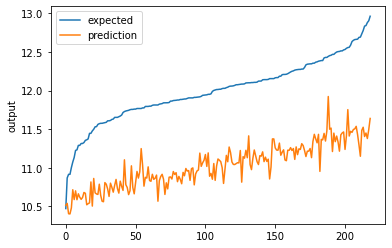

In [337]:
# Plot the chart
chart_regression(pred.flatten(),Y_val)

In [338]:
# Predict

predictions = model.predict(test)


# Create and download output file

data_to_submit = pd.DataFrame()
data_to_submit['Id'] = Id
data_to_submit['SalePrice'] = pd.DataFrame(predictions)
data_to_submit.to_csv('submission.csv', header=True, index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


In [339]:
data_to_submit.head()

,Id,SalePrice
0,1461,10.956475
1,1462,10.865273
2,1463,11.196740
3,1464,11.192498
4,1465,11.039407
